In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/perrin-freres-monthly-champagne-sales/Perrin Freres monthly champagne sales millions.csv


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.plotting import lag_plot
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
      
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("../input/perrin-freres-monthly-champagne-sales/Perrin Freres monthly champagne sales millions.csv")

In [4]:
data

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [6]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Month,106,106,1968-08,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Perrin Freres monthly champagne sales millions ?64-?72,105.0,NaN,NaN,NaN,4761.152381,2553.502601,1413.0,3113.0,4217.0,5221.0,13916.0


In [7]:
#sütun adı değiştirme 
data=data.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'Sales'})
data.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


# Kayıp Değişken Analizi

In [8]:
data.isnull().sum()

Month    1
Sales    2
dtype: int64

In [9]:
data[data.isna().any(axis=1)]

,Month,Sales
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [10]:
#etkisiz iki değişken kayıp,veriden çıkaralım.
data=data.dropna()

In [11]:
data.isnull().sum()

Month    0
Sales    0
dtype: int64

In [12]:
len(data)

105

# İstatiksel Analiz ve Görselleştirme

In [13]:
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [14]:
data.Month = pd.to_datetime(data.Month)
data = data.set_index("Month")
data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [15]:
#go.scatter ile detaylı görsellştime sağlayabiliriz.Grafiğin üzerine geldiğimizde ay ve yıl bazında satışları görebiliriz.
vis=go.Scatter(x=data.index, y=data.Sales)
py.iplot([vis])

01-1964'ten 10-1972'ye kadar elimizde veri var.

**Garifk Yorum** :Seride mevsimsellik var ve trend zamanla artıyor gibi duruyor.Mevsimsellikten kaynaklı durağan bir seri değil.Durağanlığı daha iyi anlamak için ADF testi yapılmalı.

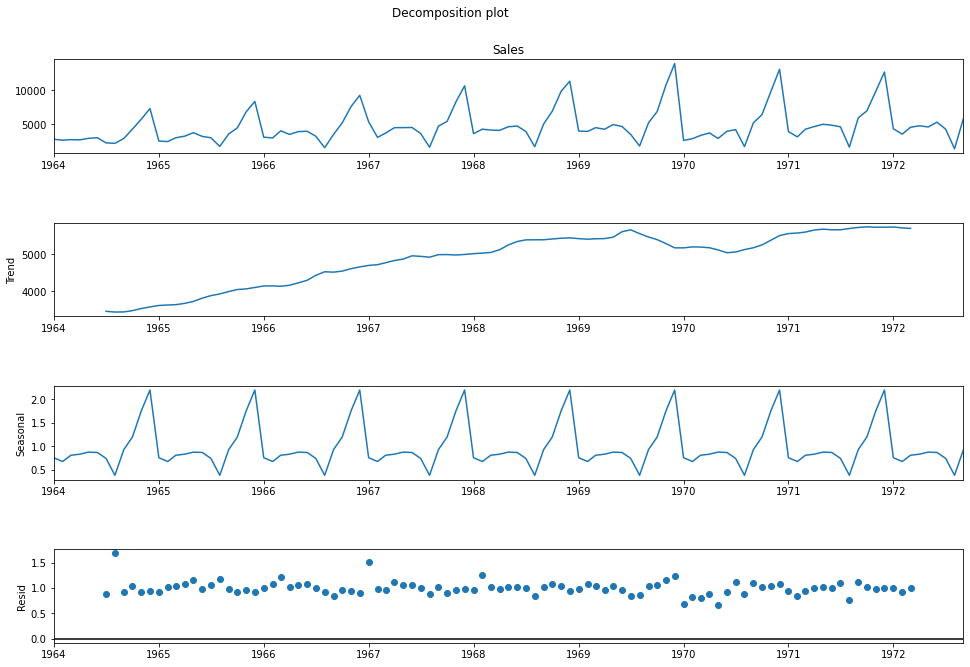

In [16]:
decomp = seasonal_decompose(data['Sales'], model='multiplicative')
fig=decomp.plot()
fig.set_size_inches(15,10)
fig.suptitle('Decomposition plot')
plt.show()

# ADF Test #

In [17]:
#H0:Zaman serisinin bir birim kökü var, yani seri durağan değil.
#H1:Zaman serisinin bir birim kökü yok, yani seri durağandır.

def adf_test(timeseries):
    
    print ('Dickey-Fuller Test Sonucu:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test İstatistiği','p-value','#Lags ','Gözlem sayısı'])
    for key,value in dftest[4].items():
       dfoutput['Kritik Değer (%s)'%key] = value
    print (dfoutput)


adf_test(data['Sales'])

Dickey-Fuller Test Sonucu:
Test İstatistiği      -1.833593
p-value                0.363916
#Lags                 11.000000
Gözlem sayısı         93.000000
Kritik Değer (1%)     -3.502705
Kritik Değer (5%)     -2.893158
Kritik Değer (10%)    -2.583637
dtype: float64


* Durağanlık Testi sonucuna göre  p-değeri> 0.05 olduğundan H0 reddedilemez (yani kabul),verinin bir birim kökü vardır ve seri durağan değildir.(aynı zamanada test istatistiği de kritik değerden büyük)


# SARIMA modeli

Seride mevsimsellik var bu yüzden ARIMA yerine SARIMA (Mevsimsel ARIMA) kullanılacak.Hem veride tek bir değişken var ve SARIMA tek değişkenli zaman serisi verilerini mevsimsel bir bileşenle desteklediğinden uygun bir model olacaktır.

In [18]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 1.3 MB/s 
     |████████████████████████████████| 2.1 MB 6.9 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 0.1.0b20210210 requires numpy==1.19, but you have numpy 1.19.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [19]:
from pmdarima.arima import auto_arima

auto_arima(data['Sales'], seasonal=True, m=12,start_p=0, 
           start_q=0, max_P=5, max_D=5,max_Q=5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  105
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -745.083
Date:                             Thu, 11 Mar 2021   AIC                           1498.167
Time:                                     18:41:21   BIC                           1508.297
Sample:                                          0   HQIC                          1502.257
                                             - 105                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    362.8395    100.620      3.606      0.000     165.628     560.051
ma.L1          0.2191      0.074      2.970      0.003       0.075       0.364
ar.S.L12      -0.1784      0.082     -2.186      0.029      -0.338      -0.018
sigma2      5.135e+05   5.75e+04      8.924      0.000    4.01e+05    6.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 8.20
Prob(Q):                              0.55   Prob(JB):                         0.02
Heteroskedasticity (H):               1.27   Skew:                            -0.15
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Train/Test Ayrımı
**Son 12 aylık veri test olarak kalan veri de train olarak ayrıldı.Tahmin 12 aylığı kapsayacak yani Ekim 1972'den Eylül 1973'e kadar.**

In [20]:
train = data[:len(data)-12]
test= data[len(data)-12:]

In [21]:
test

,Sales
Month,
1971-10-01,6981.0
1971-11-01,9851.0
1971-12-01,12670.0
1972-01-01,4348.0
1972-02-01,3564.0
1972-03-01,4577.0
1972-04-01,4788.0
1972-05-01,4618.0
1972-06-01,5312.0


In [22]:
arima_model = SARIMAX(train['Sales'], order = (0,0,1),
                      seasonal_order = (1,1,[],12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   93
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -658.802
Date:                             Thu, 11 Mar 2021   AIC                           1323.604
Time:                                     18:41:21   BIC                           1330.787
Sample:                                 01-01-1964   HQIC                          1326.486
                                      - 09-01-1971                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2631      0.091      2.887      0.004       0.084       0.442
ar.S.L12      -0.0654      0.088     -0.743      0.458      -0.238       0.107
sigma2      6.639e+05   8.97e+04      7.401      0.000    4.88e+05     8.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 7.33
Prob(Q):                              0.76   Prob(JB):                         0.03
Heteroskedasticity (H):               1.75   Skew:                            -0.29
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

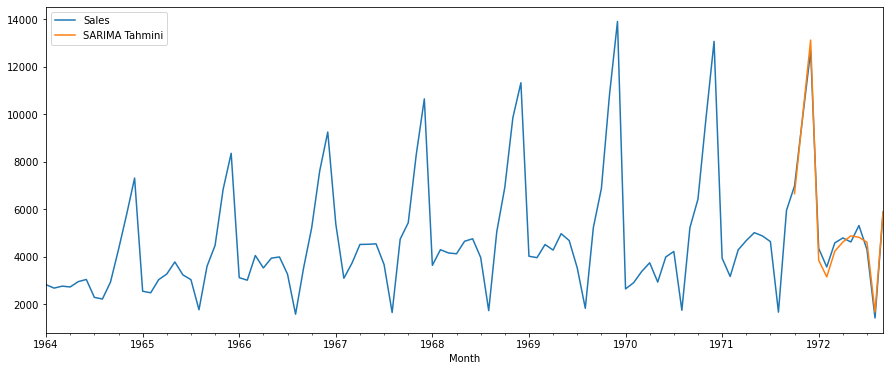

In [23]:
sarima_pred = arima_result.predict(start = len(train), end = len(data)-1, typ="levels").rename("SARIMA Tahmini")

data['Sales'].plot(figsize = (15,6), legend=True)
sarima_pred.plot(legend = True);

RMSE: 337.567


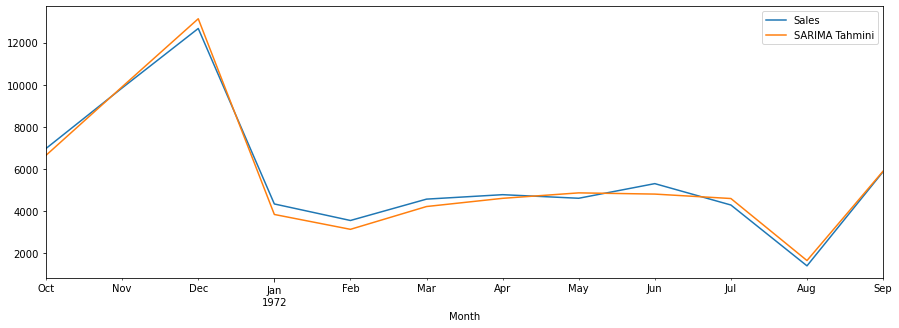

In [24]:
test['Sales'].plot(figsize = (15,5), legend=True)
sarima_pred.plot(legend = True);
rmse_sarima = rmse(test['Sales'], sarima_pred)
print('RMSE: %.3f' % rmse_sarima)

In [25]:
len(data)

105

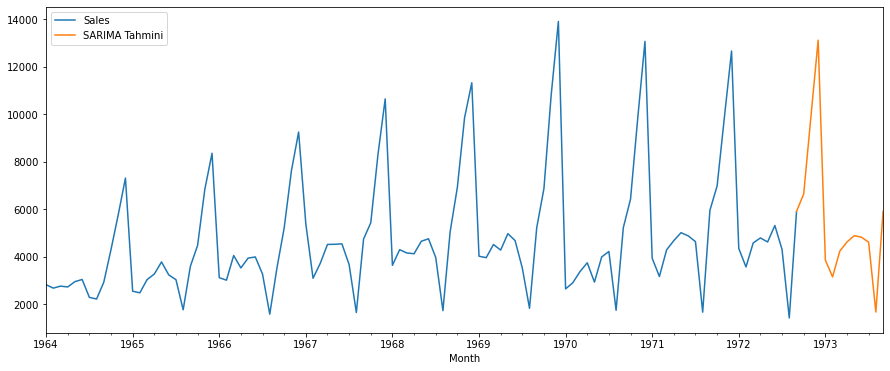

In [26]:
yeni_sarima_tahmin = arima_result.predict(start =104 , end = 116, dynamic= True).rename("SARIMA Tahmini")  
data['Sales'].plot(figsize = (15,6), legend=True)
yeni_sarima_tahmin.plot(legend = True);

# LSTM ile Tahmin

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train=scaler.fit_transform(np.array(train).reshape(-1,1))
scaled_test = scaler.transform(np.array(test).reshape(-1,1))

In [28]:
scaled_test.shape,scaled_train.shape

((12, 1), (93, 1))

In [29]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input,
                                batch_size=1)
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(12, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit_generator(generator, epochs=100)

Epoch 1/100
81/81 [==============================] - 2s 10ms/step - loss: 0.0611
Epoch 2/100
81/81 [==============================] - 1s 9ms/step - loss: 0.0434
Epoch 3/100
81/81 [==============================] - 1s 9ms/step - loss: 0.0274
Epoch 4/100
81/81 [==============================] - 1s 9ms/step - loss: 0.0288
Epoch 5/100
81/81 [==============================] - 1s 9ms/step - loss: 0.0189
Epoch 6/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0126
Epoch 7/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0091
Epoch 8/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0115
Epoch 9/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0363
Epoch 10/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0278
Epoch 11/100
81/81 [==============================] - 1s 9ms/step - loss: 0.0124
Epoch 12/100
81/81 [==============================] - 1s 9ms/step - loss: 0.0051
Epoch 13/100
81/81 [===========

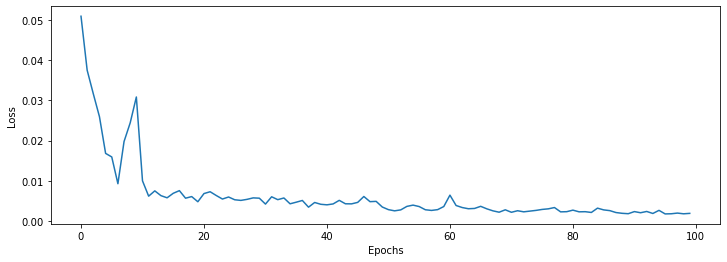

In [31]:
losses_lstm = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses_lstm)),losses_lstm);

**Test Seti ile Tahmin Edelim**

In [32]:
rescaled_test =scaled_test.reshape(scaled_test.shape[0],scaled_test.shape[1] , 1)

lstm_tahmin = model.predict(rescaled_test)

In [33]:
lstm_tahmin_retrans = scaler.inverse_transform(lstm_tahmin)

lstm_tahmin_testten=lstm_tahmin_retrans.reshape(lstm_tahmin_retrans.shape[0])
lstm_tahmin_testten_ser = pd.Series(lstm_tahmin_testten, index=test.index)

In [34]:
lstm_tahmin_testten_ser

Month
1971-10-01    4095.371094
1971-11-01    4432.440430
1971-12-01    4773.013672
1972-01-01    3791.997070
1972-02-01    3708.177734
1972-03-01    3817.661621
1972-04-01    3841.347900
1972-05-01    3822.291016
1972-06-01    3899.963623
1972-07-01    3786.515869
1972-08-01    3461.282959
1972-09-01    3965.381104
dtype: float32

RMSE: 3063.101


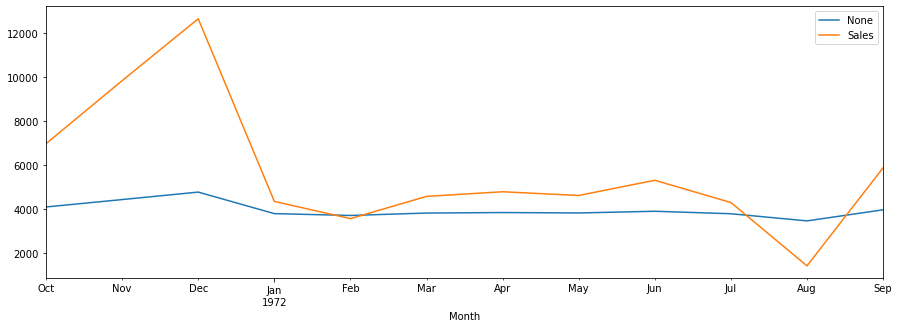

In [35]:
lstm_tahmin_testten_ser.plot(figsize = (15,5), legend=True)
test['Sales'].plot(legend = True);
rmse_lstm = rmse(test['Sales'], lstm_tahmin_testten_ser)
print('RMSE: %.3f' % rmse_lstm)

**Ekstrapolasyon (Tek değişkenli zaman serisi tahmini) ile Tahmin Edelim**

In [36]:
lstm_tahmin_scaled=list()
batch = scaled_train[-12:]
current_batch = batch.reshape((1, 12, 1))
for i in range(len(test)):   
    lstm_tahmin = model.predict(current_batch)[0]
    lstm_tahmin_scaled.append(lstm_tahmin) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_tahmin]],axis=1)

In [37]:
lstm_tahmin_ekst = scaler.inverse_transform(lstm_tahmin_scaled)

lstm_tahmin_reshape=lstm_tahmin_ekst.reshape(lstm_tahmin_ekst.shape[0])
lstm_tahmin_ekst_ser=pd.Series(lstm_tahmin_reshape,index=test.index)

RMSE: 444.974


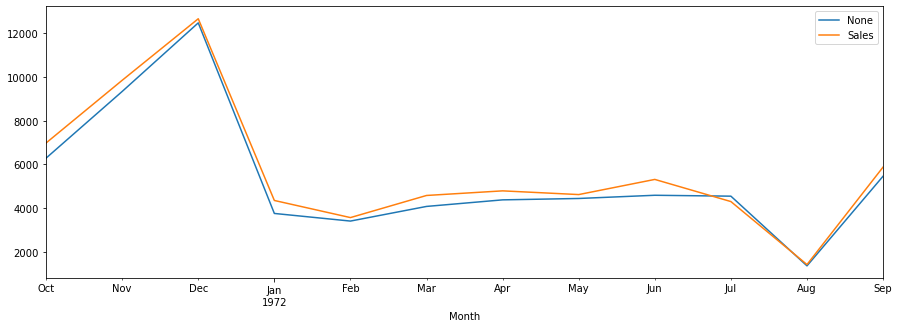

In [38]:
lstm_tahmin_ekst_ser.plot(figsize = (15,5), legend=True)
test['Sales'].plot(legend = True);
rmse_lstm = rmse(test['Sales'], lstm_tahmin_ekst_ser)
print('RMSE: %.3f' % rmse_lstm)

# Prophet ile Tahmin

In [39]:
data

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [40]:
df = data.copy()
df = df.reset_index()
df.columns = ['ds','y'] 

train_pr = df.iloc[:len(data)-12]
test_pr = df.iloc[len(data)-12:]

from fbprophet import Prophet

model_p = Prophet()
model_p.fit(train_pr)
future = model_p.make_future_dataframe(periods=12,freq='MS')

prophet_pred = model_p.predict(future)
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
100,1972-05-01,5929.506024,4258.463143,6265.164186,5923.980107,5934.688579,-697.320744,-697.320744,-697.320744,-697.320744,-697.320744,-697.320744,0.0,0.0,0.0,5232.185280
101,1972-06-01,5947.077683,4261.094150,6086.417214,5940.275211,5953.296214,-818.201248,-818.201248,-818.201248,-818.201248,-818.201248,-818.201248,0.0,0.0,0.0,5128.876435
102,1972-07-01,5964.082514,3503.445077,5365.465370,5956.290493,5971.383967,-1582.874224,-1582.874224,-1582.874224,-1582.874224,-1582.874224,-1582.874224,0.0,0.0,0.0,4381.208289
103,1972-08-01,5981.654172,2362.966553,4334.586111,5972.128224,5990.180916,-2677.889030,-2677.889030,-2677.889030,-2677.889030,-2677.889030,-2677.889030,0.0,0.0,0.0,3303.765142
104,1972-09-01,5999.225831,4339.614804,6355.230658,5988.293128,6009.352289,-645.080491,-645.080491,-645.080491,-645.080491,-645.080491,-645.080491,0.0,0.0,0.0,5354.145340


In [41]:
prophet_pred = pd.DataFrame({"Tarih" : prophet_pred[-12:]['ds'], 
                             "Prophet_Tahmin" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Tarih")
prophet_pred.index.freq = "MS"
prophet_pred

,Prophet_Tahmin
Tarih,
1971-10-01,6321.837000
1971-11-01,9322.691346
1971-12-01,11846.912670
1972-01-01,4774.756930
1972-02-01,4362.443459
1972-03-01,5157.687395
1972-04-01,4886.316086
1972-05-01,5232.185280
1972-06-01,5128.876435


RMSE: 754.079


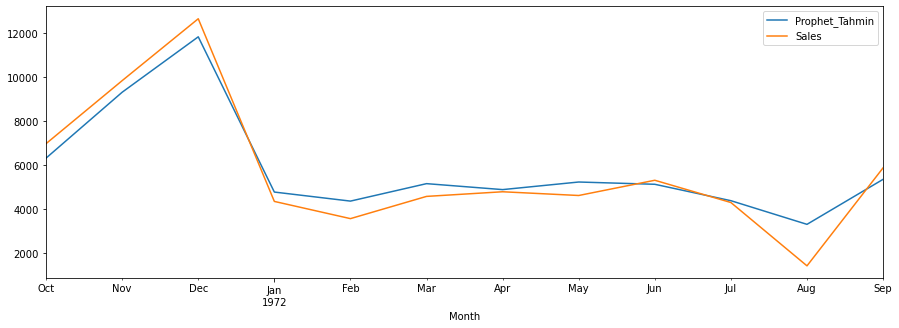

In [42]:
prophet_pred['Prophet_Tahmin'].plot(figsize = (15,5), legend=True)
test['Sales'].plot(legend = True);
rmse_lstm = rmse(test['Sales'], prophet_pred['Prophet_Tahmin'])
print('RMSE: %.3f' % rmse_lstm)

# Sonuçları Gösteren DataFrame Oluşturma

In [43]:
from pandas.tseries.offsets import DateOffset

tahmin=[data.index[-1]+ DateOffset(months=x)for x in range(0,13)]
tahmin_datası=pd.DataFrame(index=tahmin[1:])

tahmin_datası

""
1972-10-01
1972-11-01
1972-12-01
1973-01-01
1973-02-01
1973-03-01
1973-04-01
1973-05-01
1973-06-01
1973-07-01


In [44]:
tahmin_datası['SARIMA_Tahmin']=yeni_sarima_tahmin
tahmin_datası['LSTM_Tahmin']=lstm_tahmin_ekst
tahmin_datası['Prophet_Tahmin']=prophet_pred['Prophet_Tahmin'].values

In [45]:
tahmin_datası

,SARIMA_Tahmin,LSTM_Tahmin,Prophet_Tahmin
1972-10-01,6642.505887,6287.350986,6321.837000
1972-11-01,9900.741937,9339.948131,9322.691346
1972-12-01,13127.345710,12481.262619,11846.912670
1973-01-01,3854.842031,3753.665398,4774.756930
1973-02-01,3145.923903,3404.394520,4362.443459
1973-03-01,4230.008726,4075.153480,5157.687395
1973-04-01,4618.786209,4375.904567,4886.316086
1973-05-01,4882.674865,4439.200896,5232.185280
1973-06-01,4819.720250,4586.144490,5128.876435
1973-07-01,4607.571648,4545.073662,4381.208289


*Sonuç olarak en az hata değerini SARIMAX modelinin sonucu vermektedir.LSTM ise Prophet modelinden daha iyi sonuç vermiştir.*